# Air Quality Forecast
We now want to predict the air quality into the future using the now available data. Two predictions are tried: 

- Forecasting the next our using however long prior time values as feasable and senible
- Forecasting an entire day in advance, that is 24 hours in advance.

I use this tutorial as a starting point: https://www.tensorflow.org/tutorials/structured_data/time_series. This appears to be kind of advanced, I only have understood some of it. Let's see how it works out...

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense

print(tf.__version__)

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# read csv
data = pd.read_pickle("../../datasets/All.pickle")
data.index = pd.DatetimeIndex(data.DateTime)
data.head()

2022-01-25 14:46:37.014373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-25 14:46:37.014401: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.8.0-rc0


,NO2-ug-per-m3,Cars-Direction-1,Cars-Direction-2,Cars-Total,Day-Of-Week,Monday,Tuesday,Wednesday,Thursday,Friday,...,Number of vessels,DateTime,DaySin,DayCos,WeekSin,WeekCos,MonthSin,MonthCos,YearSin,YearCos
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,19.0,36,62,98,2,0,1,0,0,0,...,6,2019-01-01 00:00:00,0.000000,1.000000,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852
2019-01-01 01:00:00,11.0,109,112,221,2,0,1,0,0,0,...,4,2019-01-01 01:00:00,0.258819,0.965926,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852
2019-01-01 02:00:00,9.0,97,60,157,2,0,1,0,0,0,...,2,2019-01-01 02:00:00,0.500000,0.866025,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852
2019-01-01 03:00:00,7.0,60,44,104,2,0,1,0,0,0,...,4,2019-01-01 03:00:00,0.707107,0.707107,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852
2019-01-01 04:00:00,8.0,44,33,77,2,0,1,0,0,0,...,3,2019-01-01 04:00:00,0.866025,0.500000,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852


# Preperation

## Input parameters
For Input, Cars-Total is expected to be the singe most important factor. Other parameters are day of week, wether it is a school holyday, some weather data, price of diesel fuel, number of vessels in the channel and the time of day. Labels are the amount of NO2 in ug per m³. In this case we, of course, also use the air quality itself as input. 

## Split the data and normalize using training set 

Use 70%, 20% and 10% for training, validation and test sets.Data is not shuffled, since we are dealing with a time series where order is important. 

No normalization for now. 

In [2]:
# select columns for X and Y
full_df = data[["NO2-ug-per-m3", "Cars-Total", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday", "SchoolHoliday", "wind_meters_per_second", "rain_millimeters", "did_it_rain", "air_temp_deg_c", "relative_humidity_percent", "diesel", "Number of vessels", "DaySin", "DayCos"]]

print(full_df.shape)

#print(data_X.max())

# no normalization as before

# split data
column_indices = {name: i for i, name in enumerate(full_df.columns)}

n = len(data)
# print(n)
train_df = full_df[0:int(n*0.7)]
val_df = full_df[int(n*0.7):int(n*0.9)]
test_df = full_df[int(n*0.9):]


(8052, 19)


## Windowing
We want to make a set of predictions based on a window of consecutive examples. 

The main features of the window are: 

- The width of the input and labels
- The time offset between them
- Which features are used as input, labels and both

For this task we will define a WindowGenerator class. 

In [3]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


Example: this code creates a window which uses 24 hors as input to generate on hour of output: 

In [4]:
w_ex = WindowGenerator(input_width=24, label_width=1, shift=1, label_columns=["NO2-ug-per-m3"])
w_ex

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['NO2-ug-per-m3']

## Split method
this will split the generated windows in inputs (0-23 in the example above) and labels (24 in the example). 

In [5]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [6]:
# test it, stack three slices
example_window = tf.stack([np.array(train_df[:w_ex.total_window_size]), 
                           np.array(train_df[100:100+w_ex.total_window_size]), 
                           np.array(train_df[200:200+w_ex.total_window_size])])

example_inputs, example_labels = w_ex.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 25, 19)
Inputs shape: (3, 24, 19)
Labels shape: (3, 1, 1)


2022-01-25 14:46:40.053151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-25 14:46:40.053180: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-25 14:46:40.053201: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ak3004): /proc/driver/nvidia/version does not exist
2022-01-25 14:46:40.053531: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Plot
A plot method taken directly from the tutorial: 

In [7]:
w_ex.example = example_inputs, example_labels

def plot(self, model=None, plot_col='NO2-ug-per-m3', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

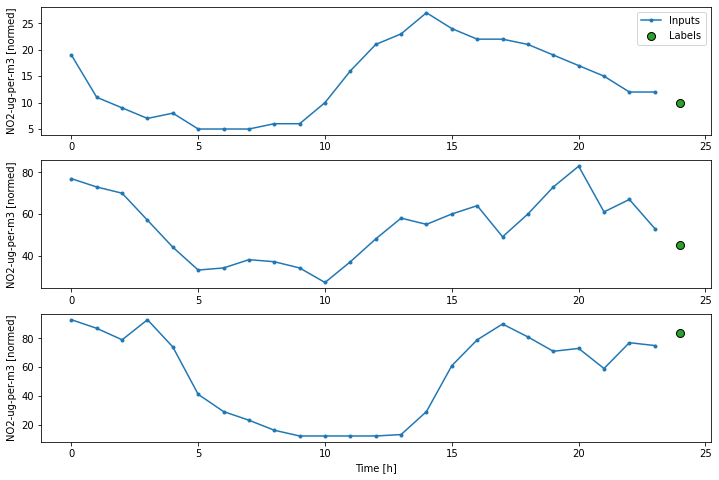

In [8]:
w_ex.plot()

## create datasets

In [9]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

# Add properties for accessing them as tf.data.Datasets using the make_dataset method you defined earlier. Also, add a standard example batch for easy access and plottin

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [10]:
w_ex.train.element_spec

for example_inputs, example_labels in w_ex.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 1, 1)


# Single Step Model
now it is time to try some models. We will first try a single step approach: we only use the inputs from one hour to predict the next hour. 

In [11]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['NO2-ug-per-m3'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['NO2-ug-per-m3']

In [12]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline
As a baseline, we will simply predict the current value. 

In [13]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline(label_index=column_indices['NO2-ug-per-m3'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


51/51 [==============================] - 0s 3ms/step - loss: 117.3468 - mean_absolute_error: 7.6426


exapmle plot:

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


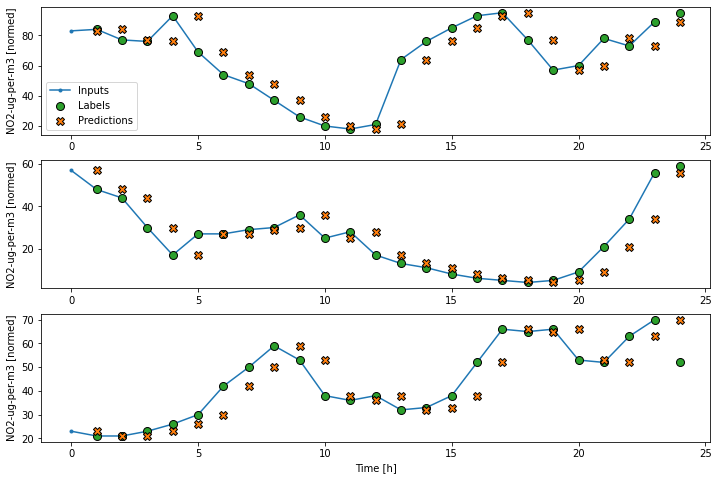

In [14]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['NO2-ug-per-m3'])

wide_window

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

wide_window.plot(baseline)


## Linear Model
Just one layer with one neuron, a simple regression: 

In [15]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


We will put the training procedure into a function to be called easier later...

In [16]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val) 
# , callbacks=[early_stopping]
  return history

In [17]:
history = compile_and_fit(linear, single_step_window)



Epoch 1/20
177/177 [==============================] - 1s 5ms/step - loss: 60983.6016 - mean_absolute_error: 207.0765 - val_loss: 29968.6914 - val_mean_absolute_error: 146.2880
Epoch 2/20
177/177 [==============================] - 1s 6ms/step - loss: 17413.9316 - mean_absolute_error: 110.5816 - val_loss: 7156.4346 - val_mean_absolute_error: 71.2186
Epoch 3/20
177/177 [==============================] - 1s 4ms/step - loss: 3810.8879 - mean_absolute_error: 50.6714 - val_loss: 1462.5691 - val_mean_absolute_error: 30.5023
Epoch 4/20
177/177 [==============================] - 1s 4ms/step - loss: 961.6754 - mean_absolute_error: 23.8562 - val_loss: 531.6899 - val_mean_absolute_error: 17.5806
Epoch 5/20
177/177 [==============================] - 1s 5ms/step - loss: 559.8868 - mean_absolute_error: 18.5334 - val_loss: 417.4466 - val_mean_absolute_error: 16.0923
Epoch 6/20
177/177 [==============================] - 1s 4ms/step - loss: 505.3111 - mean_absolute_error: 17.9901 - val_loss: 392.3048 - v

51/51 [==============================] - 0s 3ms/step - loss: 195.0815 - mean_absolute_error: 11.3345
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


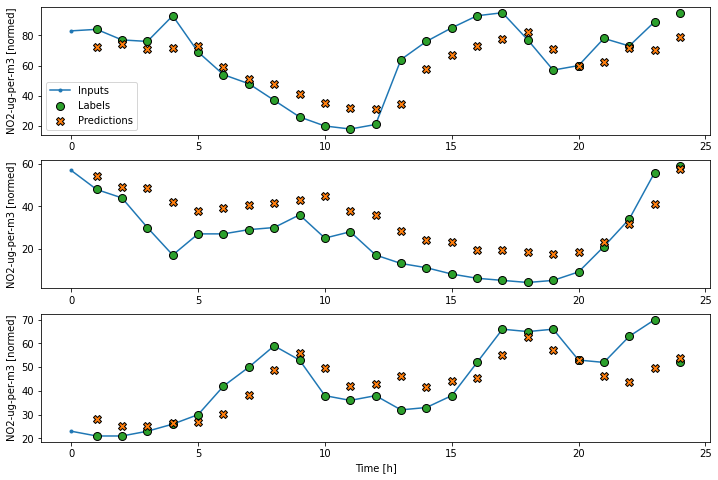

In [18]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)


print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

wide_window.plot(linear)

## Dense Model
Same as above but more layers...

In [19]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])


In [20]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/20
177/177 [==============================] - 2s 6ms/step - loss: 244.2496 - mean_absolute_error: 11.8090 - val_loss: 149.5951 - val_mean_absolute_error: 9.1979
Epoch 2/20
177/177 [==============================] - 1s 5ms/step - loss: 141.5613 - mean_absolute_error: 8.9311 - val_loss: 114.7468 - val_mean_absolute_error: 8.3064
Epoch 3/20
177/177 [==============================] - 1s 4ms/step - loss: 132.9044 - mean_absolute_error: 8.4333 - val_loss: 108.9297 - val_mean_absolute_error: 7.5896
Epoch 4/20
177/177 [==============================] - 1s 5ms/step - loss: 125.9917 - mean_absolute_error: 8.2846 - val_loss: 100.9190 - val_mean_absolute_error: 7.2878
Epoch 5/20
177/177 [==============================] - 1s 5ms/step - loss: 140.5887 - mean_absolute_error: 8.8625 - val_loss: 110.3783 - val_mean_absolute_error: 7.5333
Epoch 6/20
177/177 [==============================] - 1s 5ms/step - loss: 123.1960 - mean_absolute_error: 8.1750 - val_loss: 116.8872 - val_mean_absolute_error

51/51 [==============================] - 0s 2ms/step - loss: 92.0937 - mean_absolute_error: 6.8762

 test performance:
26/26 [==============================] - 0s 2ms/step - loss: 95.2786 - mean_absolute_error: 6.8374


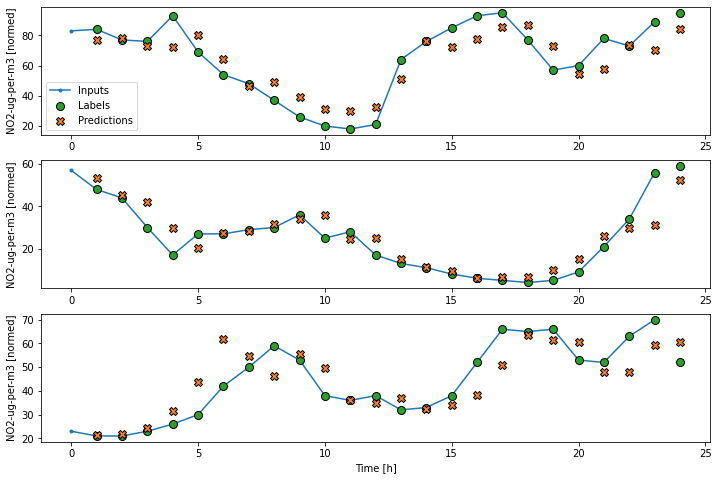

In [21]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)
print("\n test performance:")
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=1)

wide_window.plot(dense)

# Models with multiple inputs
We now go to models where we can feed a series of data as input...
CONV_WIDTH below is the actual width in hours of input. 

In [44]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['NO2-ug-per-m3'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['NO2-ug-per-m3']

## CNN
try a convolution neural network!

In [45]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [46]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [47]:
history = compile_and_fit(conv_model, conv_window)

Epoch 1/20
177/177 [==============================] - 2s 6ms/step - loss: 1076.0116 - mean_absolute_error: 20.6535 - val_loss: 154.6764 - val_mean_absolute_error: 9.4743
Epoch 2/20
177/177 [==============================] - 1s 4ms/step - loss: 147.3705 - mean_absolute_error: 9.1431 - val_loss: 102.8371 - val_mean_absolute_error: 7.4715
Epoch 3/20
177/177 [==============================] - 1s 4ms/step - loss: 120.0591 - mean_absolute_error: 8.1794 - val_loss: 132.7630 - val_mean_absolute_error: 8.6217
Epoch 4/20
177/177 [==============================] - 1s 4ms/step - loss: 114.3713 - mean_absolute_error: 7.9605 - val_loss: 85.0107 - val_mean_absolute_error: 6.8118
Epoch 5/20
177/177 [==============================] - 1s 4ms/step - loss: 101.7933 - mean_absolute_error: 7.4199 - val_loss: 103.1647 - val_mean_absolute_error: 7.4195
Epoch 6/20
177/177 [==============================] - 1s 4ms/step - loss: 100.0488 - mean_absolute_error: 7.3493 - val_loss: 127.2796 - val_mean_absolute_error

51/51 [==============================] - 0s 3ms/step - loss: 80.9289 - mean_absolute_error: 6.4468


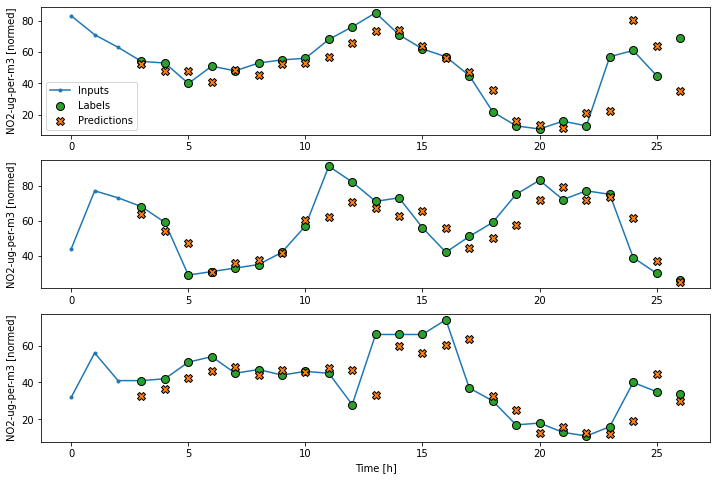

In [48]:
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['NO2-ug-per-m3'])

wide_conv_window

wide_conv_window.plot(conv_model)


## RNN
Try a Recurrent Neural Network.

In [49]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [50]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)


Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [51]:
history = compile_and_fit(lstm_model, wide_window)


Epoch 1/20
176/176 [==============================] - 5s 15ms/step - loss: 2394.2517 - mean_absolute_error: 42.0737 - val_loss: 1819.8210 - val_mean_absolute_error: 35.1967
Epoch 2/20
176/176 [==============================] - 2s 13ms/step - loss: 1803.7660 - mean_absolute_error: 34.7863 - val_loss: 1346.7675 - val_mean_absolute_error: 28.6748
Epoch 3/20
176/176 [==============================] - 2s 11ms/step - loss: 1391.6299 - mean_absolute_error: 29.4772 - val_loss: 1078.1271 - val_mean_absolute_error: 24.7722
Epoch 4/20
176/176 [==============================] - 3s 14ms/step - loss: 1155.5393 - mean_absolute_error: 26.1511 - val_loss: 899.9247 - val_mean_absolute_error: 22.0187
Epoch 5/20
176/176 [==============================] - 2s 14ms/step - loss: 976.4879 - mean_absolute_error: 23.5340 - val_loss: 760.1848 - val_mean_absolute_error: 19.7786
Epoch 6/20
176/176 [==============================] - 3s 14ms/step - loss: 832.6252 - mean_absolute_error: 21.3205 - val_loss: 647.1266 - 

50/50 [==============================] - 0s 4ms/step - loss: 128.2202 - mean_absolute_error: 7.8393


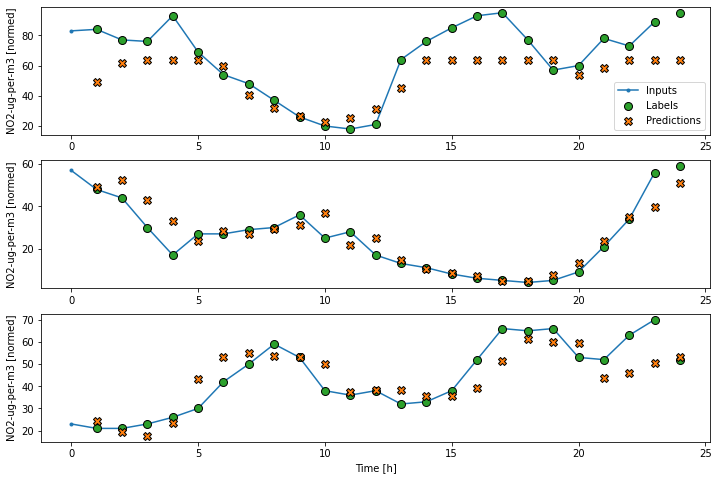

In [30]:

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

wide_window.plot(lstm_model)


# Multiple-Hour-Forecast